# Описание

Фишинговые электронные письма стали серьезной угрозой для отдельных лиц и организаций по всему миру. Эти вводящие в заблуждение электронные письма направлены на то, чтобы заставить получателей разгласить конфиденциальную информацию или совершить вредоносные действия. Обнаружение и предотвращение фишинговых писем имеет решающее значение для обеспечения личной и финансовой безопасности. В последние годы методы машинного обучения стали многообещающим подходом к борьбе с этой растущей угрозой.

Набор данных содержит три столбца: индекс, содержимое письма и тип письма (безопасное или фишинговое).

Цель: построить модель классификации, которая бы определяла по тексту письма фишинговое оно или нет.



# Библиотеки

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from statistics import mean

# Загрузка данных

In [2]:
df = pd.read_csv("Phishing_Email.csv")
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


# Разведочный анализ данных

In [3]:
df_safe_email = df[df['Email Type'] == "Safe Email"]
df_phishing_email = df[df['Email Type'] == "Phishing Email"]

In [4]:
df.isna().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [5]:
nan_rows = df[df.isna().any(axis=1)]
nan_rows

,Unnamed: 0,Email Text,Email Type
31,31,NaN,Phishing Email
387,387,NaN,Phishing Email
1883,1883,NaN,Phishing Email
2049,2049,NaN,Phishing Email
2451,2451,NaN,Phishing Email
2972,2972,NaN,Phishing Email
3627,3627,NaN,Phishing Email
3806,3806,NaN,Phishing Email
5763,5763,NaN,Phishing Email
6299,6299,NaN,Phishing Email


In [6]:
df_safe_email.isna().sum()

Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64

In [7]:
df_phishing_email.isna().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [8]:
df = df.dropna()
print(df.isna().sum())

Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64


In [9]:
print(df['Email Text'].iloc[0])

re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to " sons " being " treated like senior relatives " . for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' . for another , there seem to me to be differences here . if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e . g . , calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! ' or ' son , help me ! ' ( although perhaps these latter ones are not compl

In [10]:
df.shape

(18634, 3)

In [11]:
email_type_counts = df['Email Type'].value_counts()
print(email_type_counts)

Email Type
Safe Email        11322
Phishing Email     7312
Name: count, dtype: int64


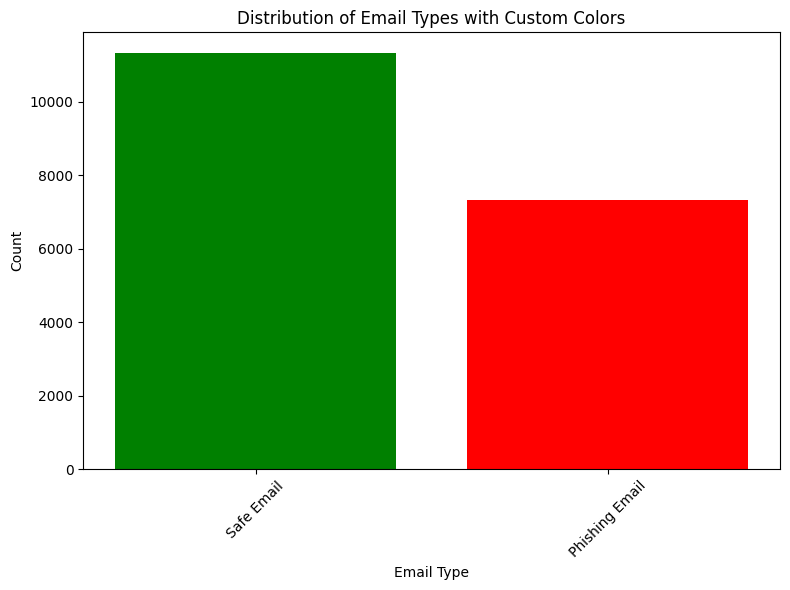

In [12]:
unique_email_types = email_type_counts.index.tolist()

color_map = {
    'Phishing Email': 'red',
    'Safe Email': 'green',}

colors = [color_map.get(email_type, 'gray') for email_type in unique_email_types]

plt.figure(figsize=(8, 6))
plt.bar(unique_email_types, email_type_counts, color=colors)
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.title('Distribution of Email Types with Custom Colors')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Предобработка данных

In [13]:
Safe_Email = df[df["Email Type"]== "Safe Email"]
Phishing_Email = df[df["Email Type"]== "Phishing Email"]
Safe_Email = Safe_Email.sample(Phishing_Email.shape[0])

In [14]:
Safe_Email.shape,Phishing_Email.shape

((7312, 3), (7312, 3))

In [15]:
Data = pd.concat([Safe_Email, Phishing_Email], ignore_index = True)
Data.head()

,Unnamed: 0,Email Text,Email Type
0,9408,With Mobile IP? Ack! 8-Ohttp://ana-www.lcs.mi...,Safe Email
1,17476,phonetics & phonology from oxford university p...,Safe Email
2,3010,third utrecht biannual phonology workshop call...,Safe Email
3,9458,"memo louise , please review and if you require...",Safe Email
4,14620,new books : historical linguistics new titles ...,Safe Email


In [16]:
Data.isna().sum()

Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64

In [34]:
Data = Data.replace('Safe Email', False).replace('Phishing Email', True)
Data["Email Type"].unique()

array([False,  True])

In [35]:
X = Data["Email Text"].values
y = Data["Email Type"].values
X_train,x_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

Основной задачей работы является обучение и оценивание моделей, которые бы классифицировали содержимое письма как фишинговое (True) или безопасное (False)

# Построение и оценивание моделей

### Random Forest Classifier

In [43]:
rfc = Pipeline([("tfidf",TfidfVectorizer() ),("classifier",RandomForestClassifier(n_estimators=10))])

In [44]:
rfc.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', RandomForestClassifier(n_estimators=10))])

In [45]:
y_pred_rfc = rfc.predict(x_test)

In [49]:
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred_rfc)}')
print(f'Classification Report: \n {classification_report(y_test, y_pred_rfc, digits=3)}')

Confusion Matrix: 
 [[2081  113]
 [ 190 2004]]
Classification Report: 
               precision    recall  f1-score   support

       False      0.916     0.948     0.932      2194
        True      0.947     0.913     0.930      2194

    accuracy                          0.931      4388
   macro avg      0.931     0.931     0.931      4388
weighted avg      0.931     0.931     0.931      4388



### SVM

In [40]:
SVM = Pipeline([("tfidf", TfidfVectorizer()),("SVM", SVC(C = 100, gamma = "auto"))])

In [41]:
SVM.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SVM', SVC(C=100, gamma='auto'))])

In [42]:
y_pred_svm = SVM.predict(x_test)

In [50]:
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred_svm)}')
print(f'Classification Report: \n {classification_report(y_test, y_pred_svm, digits=3)}')

Confusion Matrix: 
 [[1858  336]
 [  96 2098]]
Classification Report: 
               precision    recall  f1-score   support

       False      0.951     0.847     0.896      2194
        True      0.862     0.956     0.907      2194

    accuracy                          0.902      4388
   macro avg      0.906     0.902     0.901      4388
weighted avg      0.906     0.902     0.901      4388



### K-Fold и XGBoost

In [46]:
def read_data(file_path):
    data = pd.read_csv(file_path, encoding='latin-1')
    data.dropna(inplace=True)

    label_encoder = LabelEncoder()
    T_vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2), max_features=5000)

    X = data['Email Text'].values
    y = data['Email Type'].values

    for i in range(len(y)):
        if y[i] == 'Phishing Email':
            y[i] = 1
        else:
            y[i] = 0

    y = label_encoder.fit_transform(y)
    return X, y


def print_report(y_val, y_pred, fold):
    print(f'Fold: {fold}')
    print(f'Confusion Matrix: \n {confusion_matrix(y_val, y_pred)}')
    print(f'Classification Report: \n {classification_report(y_val, y_pred, digits=3)}')

In [47]:
X, y = read_data('Phishing_Email.csv')
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

print(X.shape, y.shape)

(18634,) (18634,)


In [48]:
fold = 1

for train_index, val_index in kfold.split(X):

  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

  vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 3), max_features=10000)
  vectorizer.fit(X_train)

  X_train = vectorizer.transform(X_train)
  X_val = vectorizer.transform(X_val)

  model = XGBClassifier(n_estimators=800, learning_rate=0.1, max_depth=4, colsample_bytree=0.2, n_jobs=-1, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)

  print_report(y_val, y_pred, fold)
  fold += 1

Fold: 1
Confusion Matrix: 
 [[2115   94]
 [  21 1497]]
Classification Report: 
               precision    recall  f1-score   support

           0      0.990     0.957     0.974      2209
           1      0.941     0.986     0.963      1518

    accuracy                          0.969      3727
   macro avg      0.966     0.972     0.968      3727
weighted avg      0.970     0.969     0.969      3727

Fold: 2
Confusion Matrix: 
 [[2196   83]
 [  28 1420]]
Classification Report: 
               precision    recall  f1-score   support

           0      0.987     0.964     0.975      2279
           1      0.945     0.981     0.962      1448

    accuracy                          0.970      3727
   macro avg      0.966     0.972     0.969      3727
weighted avg      0.971     0.970     0.970      3727

Fold: 3
Confusion Matrix: 
 [[2174   86]
 [  43 1424]]
Classification Report: 
               precision    recall  f1-score   support

           0      0.981     0.962     0.971      22

In [52]:
print(f'Средняя точность: {mean([0.969, 0.970, 0.965, 0.975, 0.971])}')

Средняя точность: 0.97


# Вывод

В ходе работы были построены следующие модели:
 - Random Forest Classifier,
 - SVM,
 - K-Fold + XGBoost.

В результате оценивания, было установлено, что наиболее точной моделью является K-Fold + XGBoost (при num_folds = 5) со средним результатом на уровне 0.97.

Таким образом, цель построить модель классификации, которая бы определяла по тексту письма фишинговое оно или нет, была выполнена.